### 配送パターンを利用した数理モデル
- 集合
  - 配送費の集合
  - 荷物の集合
  - 角配送日の配送パターンの集合
  - 各荷物を配送する配送パターンの集合
- 定数
  - 各配送パターンの移動時間
  - 各配送パターンの残業時間
- 固定費の定数
  - 残業費用
  - 外注費用
- 変数
    - 各配送日の配送パターンの選択
    - 荷物の外注の有無
- 制約式
  - (A') 各配送日に1つの配送パターンを選択
  - (B') 各荷物は外注するか自社配送のどちらかを選択
- 目的関数
  - (C') 費用合計と移動時間合計の最小化

In [36]:
from pulp import LpProblem, LpVariable, LpMaximize, LpMinimize, LpStatus, lpSum, value
from pulp import PULP_CBC_CMD
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time
import os
from itertools import combinations

In [5]:
# Read files
files = glob('../*/*routing_ver2/*.csv')
# print(files)
dfs, name_df = [], []
for i, file in enumerate(files):
    df_name = os.path.splitext(os.path.basename(files[i]))[0]
    name_df.append(df_name)
    df = pd.read_csv(files[i])
    dfs.append(df)
print(name_df)

['distances', 'locations', 'orders', 'small_distances', 'small_locations', 'small_orders']


In [10]:
kk_df = dfs[0]
k_df = dfs[1]
r_df = dfs[2]

In [11]:
for df in [kk_df, k_df, r_df]:
    print(df.shape)
    display(df.head())

(100, 3)


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


(10, 4)


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


(100, 5)


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


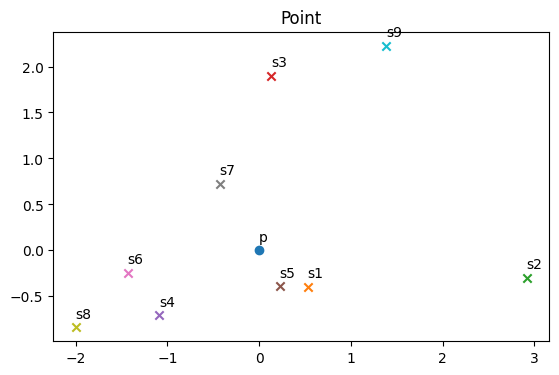

In [13]:
# display(k_df)
fig = plt.subplot()
fig.set_aspect('equal')
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x, row.y+0.1))
plt.title('Point')
plt.show()

##### 配送パターンの作成
- 実行可能なルート
  - 配送ルートは最短ルートである
  - 配送ルートの移動時間は11時間以下
- 効率的な配送パターン
  - 荷物重量は 4,000kg 以下
  - 荷物を配送しないお店に訪問する配送ルートは選択しない

In [66]:
D = list(range(r_df.b.min(), r_df.e.max()+1))
p = k_df[k_df.depo_flag == 1].k.tolist()[0]
S = k_df[k_df.depo_flag == 0].k.tolist()
K = [p] + S
R = r_df.r.tolist()

R2S = {row.r: row.s for row in r_df.itertuples()}
R2W = {row.r: row.w for row in r_df.itertuples()}
R2B = {row.r: row.b for row in r_df.itertuples()}
R2E = {row.r: row.e for row in r_df.itertuples()}
KK2T = {(row.k1, row.k2): row.t for row in kk_df.itertuples()}

In [67]:
def tsp(p_, S_, KK2T_):
    K = [p_] + S_
    KK = [(k1, k2) for k1 in K for k2 in K]

    prob = LpProblem(name='tsp', sense=LpMinimize)
    x = LpVariable.dicts('x', KK, cat='Binary')
    u = LpVariable.dicts('u', K, cat='Interger', lowBound=0)

    for k1 in K:
        prob += lpSum([x[k1, k2] for k2 in K]) == 1
        prob += lpSum([x[k2, k1] for k2 in K]) == 1

    prob += u[p_] == 0

    for s in S_:
        prob += u[s] >= 1
        prob += u[s] <= len(K) - 1

    for s1 in S_:
        for s2 in S_:
            prob += u[s1] + 1 <= u[s2] + (len(K) - 1) * (1 - x[s1, s2])

    prob += lpSum([KK2T[k1, k2] * x[k1, k2] for k1 in K for k2 in K]) <= 11
    prob += lpSum([KK2T[k1, k2] * x[k1, k2] for k1 in K for k2 in K])

    solver = PULP_CBC_CMD(msg=0)
    status = prob.solve(solver)

    if status == 1:
        X = [(k1, k2) for k1 in K for k2 in K if x[k1, k2].value() == 1]
        time = sum([KK2T_[k1, k2] for k1, k2 in X])
    else:
        X = []
        time = -1
    
    return status, X, time

In [64]:
testS1 = ['s4', 's5', 's9']
testS2 = ['s1', 's2', 's3', 's4', 's5', 's9']

for testS in [testS1, testS2]:
    status, X, time = tsp(p, testS, KK2T)
    print(f'Status: {LpStatus[status]}')
    print(f'x: {X}')
    print(f'移動時間: {time}')

Status: Optimal
x: [('p', 's4'), ('s4', 's5'), ('s5', 's9'), ('s9', 'p')]
移動時間: 8.145373915498993
Status: Infeasible
x: []
移動時間: -1


In [38]:
Stp2Pat = {}
for n in range(len(S)+1):
    count = 0
    for Stp in combinations(S, n):
        status, X, time = tsp(p, list(Stp), KK2T)

        if status == 1:
            Stp2Pat[Stp] = (X, time)
            count += 1
    print(f'訪問するお店の数: {n} 配送ルート数: {count}')
print(f'要件を満たす配送ルート数: {len(Stp2Pat)}')

訪問するお店の数: 0 配送ルート数: 1
訪問するお店の数: 1 配送ルート数: 9
訪問するお店の数: 2 配送ルート数: 36
訪問するお店の数: 3 配送ルート数: 81
訪問するお店の数: 4 配送ルート数: 107
訪問するお店の数: 5 配送ルート数: 83
訪問するお店の数: 6 配送ルート数: 37
訪問するお店の数: 7 配送ルート数: 9
訪問するお店の数: 8 配送ルート数: 1
訪問するお店の数: 9 配送ルート数: 0
要件を満たす配送ルート数: 364


In [44]:
for i, (Stp, Pat) in enumerate(Stp2Pat.items()):
    if i > 3: break
    print(f'---お店の組み合わせ: {Stp}')
    print(f'配送ルート: {Pat}')

---お店の組み合わせ: ()
配送ルート: ([('p', 'p')], 0.0)
---お店の組み合わせ: ('s1',)
配送ルート: ([('p', 's1'), ('s1', 'p')], 1.3236097970929661)
---お店の組み合わせ: ('s2',)
配送ルート: ([('p', 's2'), ('s2', 'p')], 5.865139919138787)
---お店の組み合わせ: ('s3',)
配送ルート: ([('p', 's3'), ('s3', 'p')], 3.807054271558092)


In [77]:
D2R = {d: [] for d in D}

for r in R:
    for d in range(R2B[r], R2E[r]+1):
        D2R[d].append(r)
    
# for d in D:
#     print(f'配送日: {d, D2R[d]}')

D2Pat = {d: [] for d in D}
for d in D:
    dayR = D2R[d]

    for n in range(len(dayR)+1):
        for tarR in combinations(dayR, n):
            w = sum([R2W[r] for r in tarR])
            if w > 4000:
                continue

            tarS = set([R2S[r] for r in tarR])
            tarStp = tuple(sorted(tarS))

            if tarStp in Stp2Pat:
                X, time = Stp2Pat[tarStp]
                pat = [X, time, list(tarR)]
                D2Pat[d].append(pat)
            else:
                continue
    print(f'配送日: {d}, 配送パターン数: {len(D2Pat[d])}')

配送日: 1, 配送パターン数: 31
配送日: 2, 配送パターン数: 614
配送日: 3, 配送パターン数: 503
配送日: 4, 配送パターン数: 269
配送日: 5, 配送パターン数: 260
配送日: 6, 配送パターン数: 1371
配送日: 7, 配送パターン数: 1143
配送日: 8, 配送パターン数: 1461
配送日: 9, 配送パターン数: 332
配送日: 10, 配送パターン数: 345
配送日: 11, 配送パターン数: 175
配送日: 12, 配送パターン数: 44
配送日: 13, 配送パターン数: 93
配送日: 14, 配送パターン数: 333
配送日: 15, 配送パターン数: 557
配送日: 16, 配送パターン数: 2737
配送日: 17, 配送パターン数: 3292
配送日: 18, 配送パターン数: 2416
配送日: 19, 配送パターン数: 2244
配送日: 20, 配送パターン数: 575


In [86]:
D2Q = {d: [] for d in D}
Q2R, Q2T, Q2H, Q2X = {}, {}, {}, {}

for d in D:
    for q_no, (X, time, tarR) in enumerate(D2Pat[d]):
        q = f'q_{d}_{q_no}'
        D2Q[d].append(q)
        Q2R[q] = tarR
        Q2T[q] = time
        Q2H[q] = max(time-8, 0)
        Q2X[q] = X

print(f'配送日 1 日目の配送パターン: {D2Q[1]}')

配送日 1 日目の配送パターン: ['q_1_0', 'q_1_1', 'q_1_2', 'q_1_3', 'q_1_4', 'q_1_5', 'q_1_6', 'q_1_7', 'q_1_8', 'q_1_9', 'q_1_10', 'q_1_11', 'q_1_12', 'q_1_13', 'q_1_14', 'q_1_15', 'q_1_16', 'q_1_17', 'q_1_18', 'q_1_19', 'q_1_20', 'q_1_21', 'q_1_22', 'q_1_23', 'q_1_24', 'q_1_25', 'q_1_26', 'q_1_27', 'q_1_28', 'q_1_29', 'q_1_30']


In [87]:
d = 1
for q_no, (X, time, tarR) in enumerate(D2Pat[d]):
    q = f'q_{d}_{q_no}'
    print(q)
    print(Q2R[q])
    print(Q2T[q])
    print(Q2H[q])
    print(Q2X[q])

q_1_0
[]
0.0
0
[('p', 'p')]
q_1_1
['r04']
5.865139919138787
0
[('p', 's2'), ('s2', 'p')]
q_1_2
['r46']
5.244634136752381
0
[('p', 's9'), ('s9', 'p')]
q_1_3
['r53']
5.244634136752381
0
[('p', 's9'), ('s9', 'p')]
q_1_4
['r77']
3.807054271558092
0
[('p', 's3'), ('s3', 'p')]
q_1_5
['r99']
5.244634136752381
0
[('p', 's9'), ('s9', 'p')]
q_1_6
['r04', 'r46']
8.51538202654576
0.51538202654576
[('p', 's2'), ('s2', 's9'), ('s9', 'p')]
q_1_7
['r04', 'r53']
8.51538202654576
0.51538202654576
[('p', 's2'), ('s2', 's9'), ('s9', 'p')]
q_1_8
['r04', 'r77']
8.386444478916365
0.38644447891636524
[('p', 's2'), ('s2', 's3'), ('s3', 'p')]
q_1_9
['r04', 'r99']
8.51538202654576
0.51538202654576
[('p', 's2'), ('s2', 's9'), ('s9', 'p')]
q_1_10
['r46', 'r53']
5.244634136752381
0
[('p', 's9'), ('s9', 'p')]
q_1_11
['r46', 'r77']
5.8187574526247685
0
[('p', 's3'), ('s3', 's9'), ('s9', 'p')]
q_1_12
['r46', 'r99']
5.244634136752381
0
[('p', 's9'), ('s9', 'p')]
q_1_13
['r53', 'r77']
5.8187574526247685
0
[('p', 's3'), 

In [110]:
prob = LpProblem('vrp_enum', LpMinimize)

x = {}
for d in D:
    for q in D2Q[d]:
        x[d, q] = LpVariable(f'x_{d}_{q}', cat='Binary')

y = LpVariable.dicts('y', R, cat='Continuous', lowBound=0, upBound=1)

for d in D:
    prob += lpSum([x[d, q] for q in D2Q[d]]) == 1

for r in R:
    prob += y[r] + lpSum(x[d, q] for d in D for q in D2Q[d] if r in Q2R[q]) == 1

zangyo = lpSum([3000 * Q2H[q] * x[d, q] for d in D for q in D2Q[d]])
gaityu = lpSum([46 * R2W[r] * y[r] for r in R])
time = lpSum([x[d, q] * Q2T[q] for d in D for q in D2Q[d]])

prob += zangyo + gaityu + time

solver = PULP_CBC_CMD(msg=1)
status = prob.solve(solver)
print(f'Status: {LpStatus[status]}')

Status: Optimal


In [106]:
print(f'残業費用: {zangyo.value():,.0f} [円]')
print(f'外注費用: {gaityu.value():,.0f} [円]')
print(f'費用合計: {zangyo.value() + gaityu.value():,.0f} [円]')
print(f'移動時間: {time.value():,.1f} [H]')

残業費用: 8,213 [円]
外注費用: 1,098,940 [円]
費用合計: 1,107,153 [円]
移動時間: 123.4 [H]


In [117]:
resD2Q = {d: q for d in D for q in D2Q[d] if x[d, q].value() == 1}

for d in D:
    tar_q = resD2Q[d]

    X = Q2X[tar_q].copy()
    tar = p
    Route = [p]
    while len(X) >= 1:
        for k1, k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1, k2))

    print(f'---配送日: {d}, 配送パターン: {tar_q}')
    print(f'移動時間: {Q2T[tar_q]:.2f}')
    print(f'残業時間: {Q2H[tar_q]:.2f}')
    print(f'配送ルート: {"->".join(Route)}')
    for r in Q2R[tar_q]:
        print(f'荷物{r}-お店{R2S[r]}')

---配送日: 1, 配送パターン: q_1_30
移動時間: 5.82
残業時間: 0.00
配送ルート: p->s3->s9->p
荷物r46-お店s9
荷物r53-お店s9
荷物r77-お店s3
荷物r99-お店s9
---配送日: 2, 配送パターン: q_2_358
移動時間: 9.28
残業時間: 1.28
配送ルート: p->s2->s7->s6->p
荷物r02-お店s6
荷物r04-お店s2
荷物r20-お店s6
荷物r47-お店s7
---配送日: 3, 配送パターン: q_3_290
移動時間: 4.49
残業時間: 0.00
配送ルート: p->s6->s8->s4->p
荷物r65-お店s8
荷物r78-お店s4
荷物r80-お店s6
---配送日: 4, 配送パターン: q_4_255
移動時間: 4.49
残業時間: 0.00
配送ルート: p->s6->s8->s4->p
荷物r07-お店s4
荷物r29-お店s4
荷物r56-お店s4
荷物r57-お店s8
荷物r93-お店s6
---配送日: 5, 配送パターン: q_5_240
移動時間: 6.72
残業時間: 0.00
配送ルート: p->s3->s9->s1->s5->p
荷物r73-お店s3
荷物r74-お店s1
荷物r79-お店s9
荷物r96-お店s5
---配送日: 6, 配送パターン: q_6_729
移動時間: 6.14
残業時間: 0.00
配送ルート: p->s9->s1->s5->p
荷物r23-お店s9
荷物r27-お店s5
荷物r31-お店s1
荷物r67-お店s1
---配送日: 7, 配送パターン: q_7_346
移動時間: 5.78
残業時間: 0.00
配送ルート: p->s5->s8->s7->p
荷物r33-お店s8
荷物r43-お店s5
荷物r64-お店s7
---配送日: 8, 配送パターン: q_8_1445
移動時間: 7.49
残業時間: 0.00
配送ルート: p->s5->s2->s7->p
荷物r44-お店s2
荷物r54-お店s5
荷物r75-お店s2
荷物r81-お店s7
荷物r90-お店s7
---配送日: 9, 配送パターン: q_9_242
移動時間: 8.63
残業時間: 0.63
配送ルート: p->s2->s

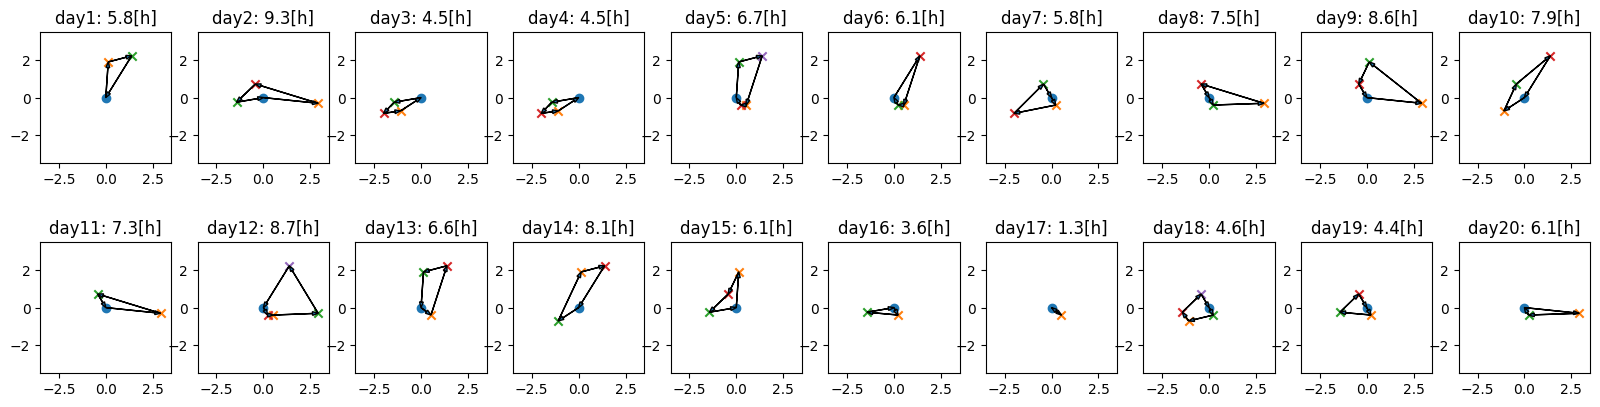

In [123]:
K2XY = {row.k: (row.x, row.y) for row in k_df.itertuples()}

fig = plt.figure(figsize=(20, 5))
for i in range(len(D)):
    d = D[i]
    tar_q = resD2Q[d]
    X = Q2X[tar_q]
    routeK = [k1 for k1, k2 in X]
    time = Q2T[tar_q]

    title_text = f'day{d}: {time:.01f}[h]'
    ax = fig.add_subplot(2, 10, i+1, title=title_text, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
    ax.set_aspect('equal')

    for row in k_df.itertuples():
        if row.k in routeK:
            if row.depo_flag:
                ax.scatter(row.x, row.y, marker='o')
            else:
                ax.scatter(row.x, row.y, marker='x')
    
    for k1, k2 in X:
        (x1, y1) = K2XY[k1]
        (x2, y2) = K2XY[k2]
        ax.arrow(x1, y1, (x2-x1), (y2-y1), head_width=0.2, length_includes_head=True)

plt.show()